In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(6,8)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv('information_security.csv')

In [3]:
data = data.drop_duplicates('text')
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x1030495583759478784,x1405214456762847240,2021-06-16 17:23:28,up_again,Priti Patel’s new threat to British journalist...,Twitter for iPhone,266,NaN,NaN,NaN,...,96371,152171,2018-08-17 16:44:27,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/10304955...,NaN,http://pbs.twimg.com/profile_images/1397433079...
1,x826314436755517441,x1405213833359249409,2021-06-16 17:21:00,Cassi__Chandler,As #healthcare organizations continue to great...,Qnary.io,268,NaN,NaN,NaN,...,74,131,2017-01-31 06:21:28,False,https://t.co/YKq9rHQYw3,https://www.linkedin.com/in/cassichandler/,NaN,https://pbs.twimg.com/profile_banners/82631443...,NaN,http://pbs.twimg.com/profile_images/8263157504...
2,x24552048,x1405213670653693952,2021-06-16 17:20:21,jsargey,"“In the next 10 years, FHE could even help res...",Twitter Web App,201,NaN,NaN,NaN,...,3994,9027,2009-03-15 17:15:52,False,https://t.co/3RVlHQQU1N,http://jennasargent.contently.com,NaN,https://pbs.twimg.com/profile_banners/24552048...,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/1270890100...
3,x1279673714603429888,x1405213608880099335,2021-06-16 17:20:06,Manfrida4,@JoyNewsOnTV The police must review their SOPs...,Twitter Web App,255,x1405188710887477249,x610124383,JoyNewsOnTV,...,479,108,2020-07-05 07:09:42,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/12796737...,NaN,http://pbs.twimg.com/profile_images/1279676445...
4,x3283206152,x1405213605734256646,2021-06-16 17:20:05,NPC_INDIA_GOV,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Pr...",Hootsuite Inc.,279,NaN,NaN,NaN,...,22449,9498,2015-07-18 09:15:18,True,https://t.co/h1j0UFKiph,http://www.npcindia.gov.in,NaN,https://pbs.twimg.com/profile_banners/32832061...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/6723169078...


In [4]:
data.shape

(7052, 90)

In [5]:
df = data[["text", "is_quote", "is_retweet", "retweet_count", "hashtags", "followers_count"]]

In [6]:
text = df[["text"]][:10000] # using subset for now so it will run faster
pd.set_option('display.max_colwidth', -1)
text.head()

,text
0,"Priti Patel’s new threat to British journalists \r\n\r\nBloody hell she’s at it again; change to Secrecy Laws, journalists and others in jail for 14 years for publishing information the government claims damages national security. Authoritarianism https://t.co/2heTpFNi4l"
1,"As #healthcare organizations continue to greatly depend on the flow of information to better support patient care, they must establish better security practices. This is where the secure access service edge (SASE) model comes in. #Cybersecurity https://t.co/X9VE9zmNUb"
2,"“In the next 10 years, FHE could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples."" https://t.co/3szQeo15Us"
3,@JoyNewsOnTV The police must review their SOPs and do a corrective action and preventive action to address this national security issues. We have cameras all over but are they working? Information gathering and all. How long are we going to sit down. What is the plan?
4,"Join \r\n@NPC_INDIA_GOV webinar on ""Manuals Preparation to Document ISO 27001:2013 Information Security Management System""\r\nDate &amp; Time: 19-06-2021 (03:30 PM to 05:00 PM)\r\nTo Register: https://t.co/4MQ2ap3iEl\r\nFee: Rs 499/-\r\nContact: chandigarh@npcindia.gov.in, 7589239766\r\n#npcindia https://t.co/Jb5gVzDcUy"


In [7]:
wnet = WordNetLemmatizer()
port = PorterStemmer()

In [8]:
def cleanTxt(txt):
    txt = txt.lower()
    txt = re.sub(r'RT[\s]+', '', txt) #removing RT
    txt = re.sub(r'[^\w\s]','', txt) #remove everything except words and space
    txt = re.sub(r'_','', txt) #how to remove underscore as well
    if 'https' in txt: # removing hyperlinks 
        pos = txt.find('https')
        txt = txt[:pos]
    return txt

In [9]:
text['text'] = text['text'].apply(cleanTxt)
text.head()

,text
0,priti patels new threat to british journalists \r\n\r\nbloody hell shes at it again change to secrecy laws journalists and others in jail for 14 years for publishing information the government claims damages national security authoritarianism
1,as healthcare organizations continue to greatly depend on the flow of information to better support patient care they must establish better security practices this is where the secure access service edge sase model comes in cybersecurity
2,in the next 10 years fhe could even help researchers find associations between specific gene mutations by analyzing genetic information across thousands of encrypted samples
3,joynewsontv the police must review their sops and do a corrective action and preventive action to address this national security issues we have cameras all over but are they working information gathering and all how long are we going to sit down what is the plan
4,join \r\nnpcindiagov webinar on manuals preparation to document iso 270012013 information security management system\r\ndate amp time 19062021 0330 pm to 0500 pm\r\nto register


In [34]:
def stopWords(txt): 
    txt_lst = txt.split(" ")
    txt_lst = [word for word in txt_lst if word not in stopwords.words('english')]
    txt_lst = [wnet.lemmatize(word) for word in txt_lst]
    txt_lst = [word for word in txt_lst if word != '']
    txt_lst = [word for word in txt_lst if word != '\r\n\r\n'] # indicates space and indexing
    txt_lst = [word for word in txt_lst if word != 'u0001f449'] # indicates back hand emoji pointing right
    txt_lst = [word for word in txt_lst if word != 'information']
    txt_lst = [word for word in txt_lst if word != 'security']
    txt_lst = [word for word in txt_lst if word != 'u']
    return " ".join(txt_lst)

In [35]:
text['text'] = text['text'].apply(stopWords)
text.head()

,text
0,priti patels new threat british journalist \r\n\r\nbloody hell shes change secrecy law journalist others jail 14 year publishing government claim damage national authoritarianism
1,healthcare organization continue greatly depend flow better support patient care must establish better practice secure access service edge sase model come cybersecurity
2,next 10 year fhe could even help researcher find association specific gene mutation analyzing genetic across thousand encrypted sample
3,joynewsontv police must review sop corrective action preventive action address national issue camera working gathering long going sit plan
4,join \r\nnpcindiagov webinar manual preparation document iso 270012013 management system\r\ndate amp time 19062021 0330 pm 0500 pm\r\nto register


In [36]:
text_lst = []
for row in text['text']:
    text_lst.append(row)

text_lst[:5]

['priti patels new threat british journalist \r\n\r\nbloody hell shes change secrecy law journalist others jail 14 year publishing government claim damage national authoritarianism',
 'healthcare organization continue greatly depend flow better support patient care must establish better practice secure access service edge sase model come cybersecurity',
 'next 10 year fhe could even help researcher find association specific gene mutation analyzing genetic across thousand encrypted sample',
 'joynewsontv police must review sop corrective action preventive action address national issue camera working gathering long going sit plan',
 'join \r\nnpcindiagov webinar manual preparation document iso 270012013 management system\r\ndate amp time 19062021 0330 pm 0500 pm\r\nto register']

In [37]:
tv = TfidfVectorizer(
binary = True, norm = None,
use_idf = False, smooth_idf = False,
lowercase = True, stop_words = None,
min_df = 1, max_df = 1.0, max_features = None, ngram_range = (1,1))

In [38]:
text_vec = pd.DataFrame(tv.fit_transform(text_lst).toarray(), columns = tv.get_feature_names())
text_vec.head()

,0000,0088,01,0113,0121,01227,01432,01482,0151,01552,...,zoo,zoom,zscaler,zu,zubair,zuckerberg,zvakaoma,zx,zyalsss,zürich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
text_vec.shape

(7052, 18520)

In [40]:
cs_words = []

for row in text['text']:
    for word in str(row).split(" "):
        cs_words.append(word)
        
cs_words[:5]

['priti', 'patels', 'new', 'threat', 'british']

In [41]:
len(cs_words)

117547

In [42]:
from nltk.probability import FreqDist
fdist = FreqDist()
for word in cs_words:
    fdist[word]+=1
fdist

FreqDist({'please': 798, 'amp': 727, 'personal': 722, 'account': 672, 'data': 613, 'like': 553, 'share': 475, 'hi': 469, 'reason': 452, 'job': 442, ...})

In [43]:
freq_data = pd.DataFrame.from_dict(fdist.most_common(20))

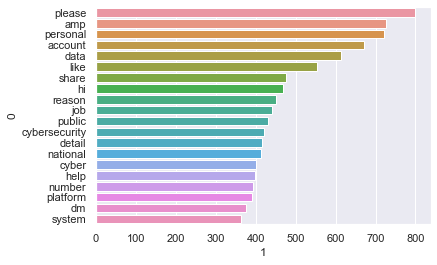

In [44]:
sns.barplot(data = freq_data, x = 1, y = 0);

In [45]:
most_common = []

for key in fdist.most_common(20):
    most_common.append(key[0])
    
most_common

['please',
 'amp',
 'personal',
 'account',
 'data',
 'like',
 'share',
 'hi',
 'reason',
 'job',
 'public',
 'cybersecurity',
 'detail',
 'national',
 'cyber',
 'help',
 'number',
 'platform',
 'dm',
 'system']

In [46]:
def evaluate_k_kmeans_inertia(k):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(text_vec)
    return estimator_kmeans.inertia_

In [47]:
%%time 
range_k = [i for i in range(1, 9)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

running Kmeans with k=1
running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=6
running Kmeans with k=7
running Kmeans with k=8
Wall time: 3min 45s


In [48]:
results_k

{1: 112209.13031763997,
 2: 108751.2171660807,
 3: 107833.19787792712,
 4: 107583.2215750662,
 5: 106469.83260738797,
 6: 105851.97839229958,
 7: 106237.17165583032,
 8: 104494.26794183956}

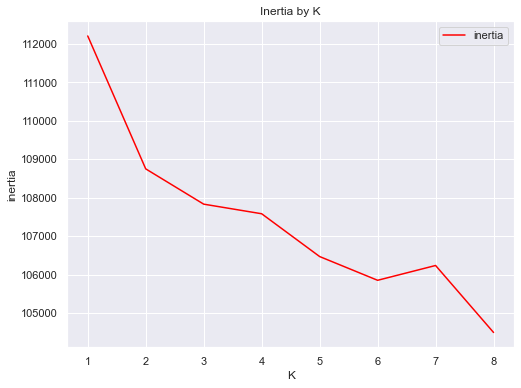

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

In [50]:
estimator_kmeans = KMeans(random_state=42, n_clusters=6) 
estimator_kmeans.fit(text_vec)

KMeans(n_clusters=6, random_state=42)

In [51]:
text_vec["cluster_id"] = estimator_kmeans.labels_
text_vec.head()

,0000,0088,01,0113,0121,01227,01432,01482,0151,01552,...,zoom,zscaler,zu,zubair,zuckerberg,zvakaoma,zx,zyalsss,zürich,cluster_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [52]:
text_clusters = text_vec.groupby('cluster_id').sum()
text_clusters.head()

,0000,0088,01,0113,0121,01227,01432,01482,0151,01552,...,zoo,zoom,zscaler,zu,zubair,zuckerberg,zvakaoma,zx,zyalsss,zürich
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [53]:
text_clusters_20 = text_clusters[['please',
 'amp',
 'personal',
 'account',
 'data',
 'like',
 'share',
 'hi',
 'reason',
 'job',
 'public',
 'cybersecurity',
 'detail',
 'national',
 'cyber',
 'help',
 'number',
 'platform',
 'dm',
 'system']
]

text_clusters_20.head()

,please,amp,personal,account,data,like,share,hi,reason,job,public,cybersecurity,detail,national,cyber,help,number,platform,dm,system
cluster_id,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,146.0,464.0,185.0,113.0,0.0,279.0,118.0,65.0,48.0,320.0,145.0,392.0,70.0,375.0,304.0,235.0,124.0,99.0,16.0,355.0
2,184.0,0.0,185.0,167.0,0.0,185.0,185.0,185.0,182.0,0.0,185.0,0.0,175.0,0.0,0.0,6.0,3.0,185.0,122.0,0.0
3,10.0,49.0,56.0,7.0,542.0,24.0,22.0,7.0,3.0,6.0,18.0,48.0,13.0,17.0,49.0,40.0,19.0,6.0,1.0,42.0
4,354.0,36.0,198.0,277.0,3.0,51.0,53.0,218.0,133.0,0.0,77.0,0.0,132.0,1.0,3.0,117.0,164.0,24.0,235.0,6.0


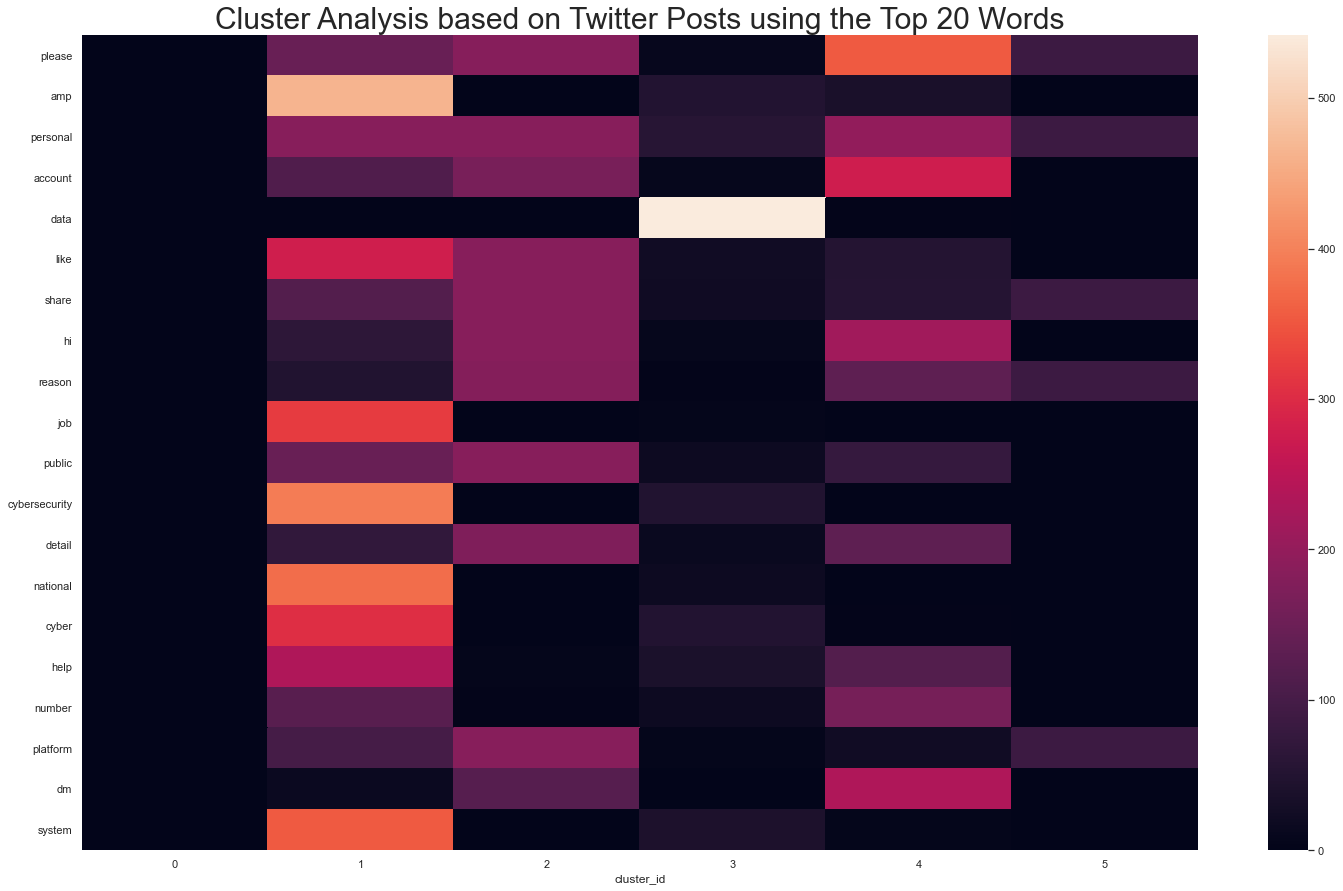

In [54]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(text_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Posts using the Top 20 Words", size = 30);

In [80]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

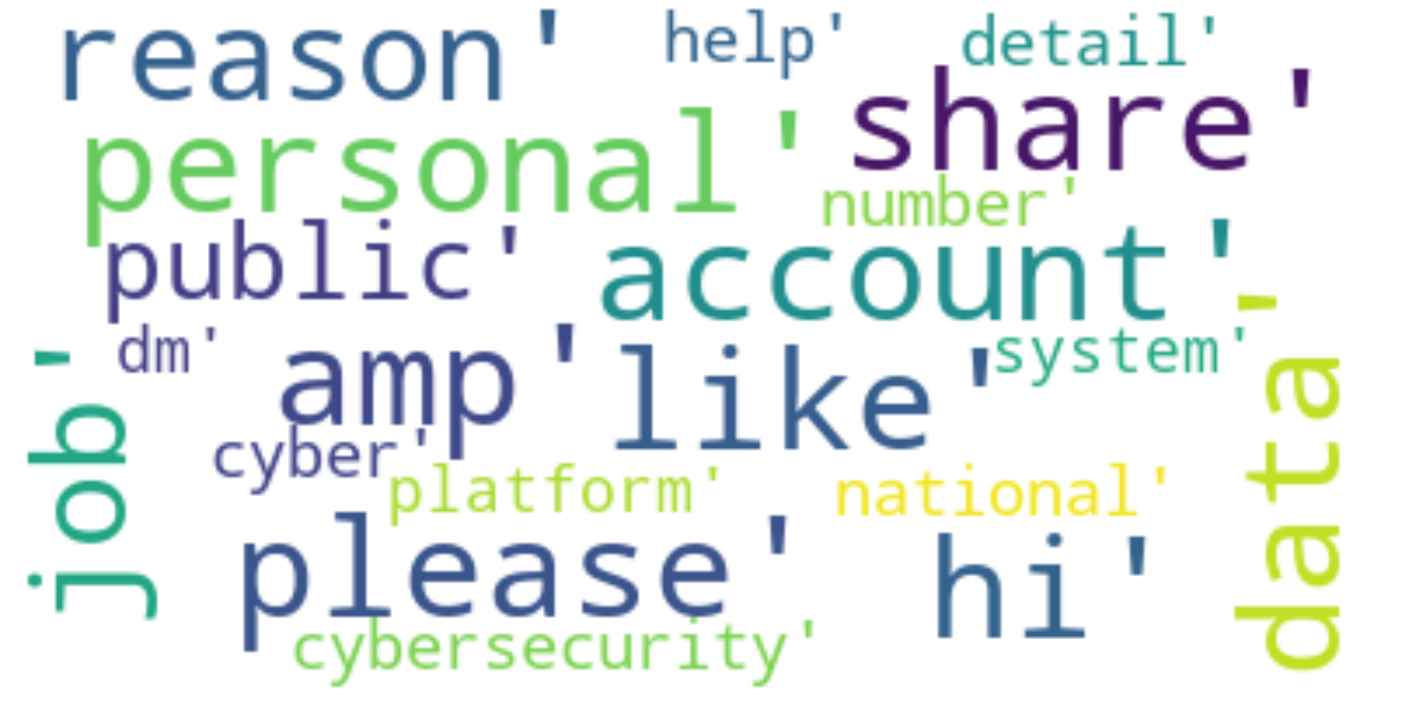

In [81]:
stopwords = set(STOPWORDS)
new_stopwords=stopwords.union(most_common)
wc = WordCloud(
         background_color="white", max_words=2000, 
         min_font_size =15, max_font_size=40, relative_scaling = 
         0.5, stopwords=new_stopwords,normalize_plurals= True)
import re 
textonly = re.sub(" ", " ",str(most_common))
wc.generate(textonly)
plt.figure(figsize=(25,25))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

#Show the wordcloud
plt.show()
#doesn't really make sense